In [59]:

from torch_geometric.data import Data
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
from torch_geometric.nn import GATv2Conv

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import time

from torch_geometric.loader import DataLoader

import torch_geometric.transforms as T

In [60]:
import gzip,os
import pandas as pd
import torch
from torch_geometric.data import Data, Dataset, DataLoader

from torch_geometric.utils import one_hot

def read_gzipped_csv(file_path):
    #include the header
    df = pd.read_csv(gzip.open(file_path), header=None)
    return df

class MyDataset(Dataset):
    types_inputs = ['Train', 'Test', 'Val']
    def __init__(self, root, typeInput='Train', transform=None, pre_transform=None):
        super(MyDataset, self).__init__(root, transform, pre_transform)
        dataset_path = os.path.join(root)

        #check if type is in types
        if typeInput not in self.types_inputs:
            raise ValueError('typeInput must be one of %r.' % self.types_inputs)

        self.typeInput = typeInput

        # Load your dataset files here
        if typeInput != 'Test':
            self.graph_labels = read_gzipped_csv(dataset_path +  '/graph_labels.csv.gz')

        self.num_nodes = read_gzipped_csv(dataset_path +  '/num_nodes.csv.gz')
        self.num_edges = read_gzipped_csv(dataset_path + '/num_edges.csv.gz')
        self.node_features = read_gzipped_csv(dataset_path +  '/node_features.csv.gz')
        self.edges = read_gzipped_csv(dataset_path +  '/edges.csv.gz')
        self.edge_features = read_gzipped_csv(dataset_path +  '/edge_features.csv.gz')
        #define a dataframe which stroes the start of node_features for each graph
        self.node_features_start = pd.DataFrame(columns=['start'])
        self.node_features_start.loc[0] = 0
        for i in range(1, len(self.num_nodes)):
            self.node_features_start.loc[i] = self.node_features_start.loc[i-1] + self.num_nodes.iloc[i-1, 0]
        #define a dataframe which stroes the start of edge_features for each graph
        self.edge_features_start = pd.DataFrame(columns=['start'])
        self.edge_features_start.loc[0] = 0
        for i in range(1, len(self.num_edges)):
            self.edge_features_start.loc[i] = self.edge_features_start.loc[i-1] + self.num_edges.iloc[i-1, 0]


        if typeInput != 'Test':
            
            valid_indices = ~self.graph_labels.iloc[:, 0].isna()
            self.graph_labels = self.graph_labels[valid_indices].reset_index(drop=True)
            self.num_nodes = self.num_nodes[valid_indices].reset_index(drop=True)
            self.num_edges = self.num_edges[valid_indices].reset_index(drop=True)
            self.node_features_start = self.node_features_start[valid_indices].reset_index(drop=True)
            self.edge_features_start = self.edge_features_start[valid_indices].reset_index(drop=True)

        if typeInput == 'Train':
            #oversample the minority class
            last_index = len(self.num_nodes)
             
            count0 = self.graph_labels[self.graph_labels[0] == 0].count().iloc[0]
            count1 = self.graph_labels[self.graph_labels[0] == 1].count().iloc[0]
            minclass = 0
            mincount = count0
            if count0 > count1:
                minclass = 1
                mincount = count1
            majcount = max(count0, count1)
            cur_ind = 0
            while mincount < majcount:
                if self.graph_labels.iloc[cur_ind, 0] == minclass:
                    self.graph_labels.loc[last_index] = self.graph_labels.iloc[cur_ind]
                    self.num_nodes.loc[last_index] = self.num_nodes.iloc[cur_ind]
                    self.num_edges.loc[last_index] = self.num_edges.iloc[cur_ind]
                    self.node_features_start.loc[last_index] = self.node_features_start.iloc[cur_ind]
                    self.edge_features_start.loc[last_index] = self.edge_features_start.iloc[cur_ind]
                    mincount += 1
                    last_index += 1
                cur_ind += 1

    def len(self):
        return len(self.num_nodes)

    def get(self, idx):
        num_nodes = self.num_nodes.iloc[idx, 0]
        num_edges = self.num_edges.iloc[idx, 0]

        # Extract node features for the current graph
        start_node_features = self.node_features_start.iloc[idx, 0]
        end_node_features = start_node_features + num_nodes
        #datatype of node_features is numpy.ndarray
        node_features = torch.tensor(self.node_features.iloc[start_node_features:end_node_features, :].values, dtype=torch.float32)

        # Extract edge features for the current graph
        start_edge_features = self.edge_features_start.iloc[idx, 0]
        end_edge_features = start_edge_features + num_edges
        edge_features = torch.tensor(self.edge_features.iloc[start_edge_features:end_edge_features, :].values, dtype=torch.float32)

        # Extract edges for the current graph
        edges = torch.tensor(self.edges.iloc[start_edge_features:end_edge_features, :].values, dtype=torch.long)

        # Construct the graph
        if self.typeInput != 'Test':
            label = self.graph_labels.iloc[idx, 0]
            label = torch.tensor(self.graph_labels.iloc[idx, 0], dtype=torch.float32).round().long()
            #make label one dimensional
            label_shape = [1]
            labelo = torch.zeros(label_shape, dtype=torch.long)
            labelo[0] = label
            label = labelo
            graph = Data(x=node_features, edge_index=edges.t().contiguous(), edge_attr=edge_features, y=label)
        else:
            graph = Data(x=node_features, edge_index=edges.t().contiguous(), edge_attr=edge_features)        
    
        return graph

In [83]:
class GNNStack(nn.Module):

    negative_slope = 0.2
    heads = 2
    dropout = 0
    
    def __init__(self, input_dim, hidden_dim, output_dim, edge_dim=3):
        super(GNNStack, self).__init__()
        print("GNNStack init with head %d, hidden_dim %d, output_dim %d" % (self.heads, hidden_dim, output_dim))
        # Convolutional layers
        self.convs = nn.ModuleList([
            GATv2Conv(input_dim, hidden_dim, heads=self.heads,  edge_dim=edge_dim),
            GATv2Conv(hidden_dim * self.heads, hidden_dim, heads=self.heads,  edge_dim=edge_dim),
        ])

        # Layer normalization
        self.lns = nn.ModuleList([nn.LayerNorm(hidden_dim * self.heads)])

        # Post-message-passing layers
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim * self.heads, hidden_dim),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

        
        self.num_layers = len(self.convs)



    def forward(self, data):
        x, edge_index, batch,edge_attr = data.x, data.edge_index, data.batch,data.edge_attr

        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_attr=edge_attr)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if i < self.num_layers - 1:
                x = self.lns[i](x)

        x = pyg_nn.global_max_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)


In [84]:
Epochs = 100

def train(dataset, val_dataset):


    loader = DataLoader(dataset, batch_size=2048, shuffle=True)
    test_loader = DataLoader(val_dataset, batch_size=1024, shuffle=True)

    # Build model
    #get edge dim from data
    edge_dim = dataset[0].edge_attr.shape[1]
    model = GNNStack(9, 32, 2, edge_dim=edge_dim)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    
    # Train
    training_loss = []
    validation_acc = []
    start_time = time.time()
    epoch = 0
    while time.time() - start_time < 60 * 25 and epoch < Epochs:
        total_loss = 0
        model.train()
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            _, pred = model(batch)
            loss = model.loss(pred, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs

        total_loss /= len(loader.dataset)
        training_loss.append(total_loss)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Training Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            validation_acc.append(test_acc)

        epoch += 1

    return model, training_loss, validation_acc

In [85]:
def test(loader, model):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    correct = 0
    for data in loader:
        with torch.no_grad():
            data = data.to(device)
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        correct += pred.eq(label).sum().item()

    total = len(loader.dataset)
    return correct / total

In [100]:
def return_pred(loader, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    pred_list = []
    for data in loader:
        with torch.no_grad():
            data = data.to(device)
            _, pred = model(data)
            pred = pred.argmax(dim=1)
            pred_list.append(pred)
    pred_list = torch.cat(pred_list).cpu().numpy()
    return pred_list

In [87]:
train_dataset_path = "/home/slowblow/sem7/col761/ass-git/A3/dataset/dataset_2/train"
train_dataset = MyDataset(root=train_dataset_path)
# train_dataset = train_dataset.shuffle()

In [89]:

valid_dataset_path = "/home/slowblow/sem7/col761/ass-git/A3/dataset/dataset_2/valid"
valid_dataset = MyDataset(root=valid_dataset_path, typeInput='Val')

In [90]:
model, training_losses, validation_acc = train(train_dataset, valid_dataset)

/home/slowblow/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/slowblow/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


cuda
Epoch 0. Training Loss: 0.6877. Test accuracy: 0.6662
cuda
Epoch 10. Training Loss: 0.6208. Test accuracy: 0.6434
cuda
Epoch 20. Training Loss: 0.5981. Test accuracy: 0.5330
cuda
Epoch 30. Training Loss: 0.5829. Test accuracy: 0.5596
cuda
Epoch 40. Training Loss: 0.5354. Test accuracy: 0.6332
cuda
Epoch 50. Training Loss: 0.5178. Test accuracy: 0.6447
cuda
Epoch 60. Training Loss: 0.5341. Test accuracy: 0.5393
cuda
Epoch 70. Training Loss: 0.4878. Test accuracy: 0.5165
cuda
Epoch 80. Training Loss: 0.4668. Test accuracy: 0.6193
cuda
Epoch 90. Training Loss: 0.4689. Test accuracy: 0.6701


In [96]:
test_loader = DataLoader(train_dataset, batch_size=1024)
pred = return_pred(train_dataset,model=model)

/home/slowblow/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


cuda


In [98]:
acc = test(test_loader, model=model)
print(acc)

cuda
0.787380906085942


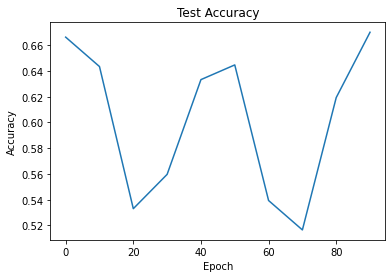

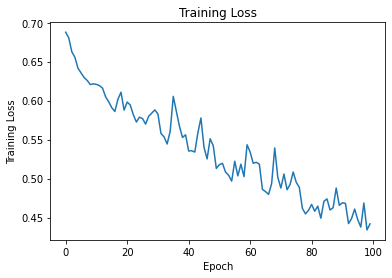

In [91]:
import matplotlib.pyplot as plt

#plot training loss and test accuracy
epochs = []
#fill from 0 to end
for i in range(len(validation_acc)):
    epochs.append(i*10)

#plot test accuracy
plt.plot(epochs, validation_acc)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


#plot training loss
epochs = []
for i in range(len(training_losses)):
    epochs.append(i)
plt.plot(epochs, training_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

#

In [101]:
from sklearn.metrics import roc_auc_score
def _eval_rocauc(self, y_true, y_pred):
        '''
            compute ROC-AUC averaged across tasks
        '''

        rocauc_list = []

        for i in range(y_true.shape[1]):
            #AUC is only defined when there is at least one positive data.
            if np.sum(y_true[:,i] == 1) > 0 and np.sum(y_true[:,i] == 0) > 0:
                # ignore nan values
                is_labeled = y_true[:,i] == y_true[:,i]
                rocauc_list.append(roc_auc_score(y_true[is_labeled,i], y_pred[is_labeled,i]))

        if len(rocauc_list) == 0:
            raise RuntimeError('No positively labeled data available. Cannot compute ROC-AUC.')

        return {'rocauc': sum(rocauc_list)/len(rocauc_list)}

In [102]:
test_dataset_path = "/home/slowblow/sem7/col761/ass-git/A3/dataset/dataset_2/valid"
test_dataset = MyDataset(root=test_dataset_path, typeInput='Val')
test_loader = DataLoader(test_dataset, batch_size=1024)
pred = return_pred(test_dataset,model=model)

/home/slowblow/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


cuda


In [105]:
true_labels = []
for graph in test_dataset:
    true_labels.append(graph.y.item())
true_labels = np.array(true_labels)


In [106]:
print(pred, true_labels)

[1 0 0 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0
 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1
 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0
 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1
 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1 1
 1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1
 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0
 0 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1
 0 0 0 1 0 1 0 0 0 1 1 0 

In [107]:
print(roc_auc_score(true_labels,pred))

0.6656301824212273


In [99]:

acc = test(test_loader, model)
print(acc)

cuda
0.787380906085942


In [94]:
import networkx as nx

def visualize_graph(graph):
    G = nx.DiGraph()
    G.add_nodes_from(range(graph.x.shape[0]))
    #add edges
    edge_index = graph.edge_index
    edge_index = edge_index.t().tolist()
    G.add_edges_from(edge_index)
    #visualize the graph
    nx.draw(G, with_labels=True,  font_color='black', font_weight='bold')
    #make title for graph using its label
    #label is 0 or 1
    label = graph.y.item()
    print(label)
    
    plt.suptitle('Graph with label ' + str(label))
    plt.show()

0


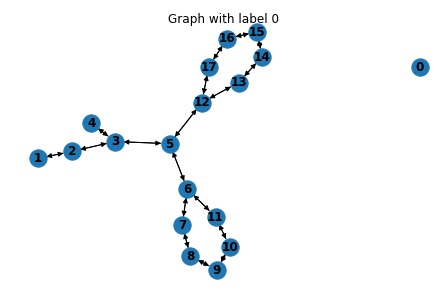

tensor([1], device='cuda:0')
0.0
------------------
1


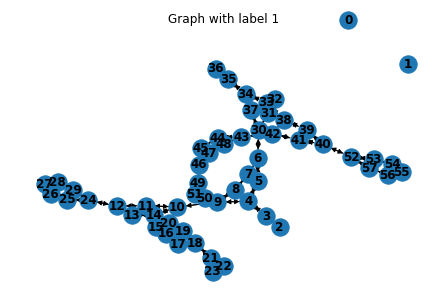

tensor([0], device='cuda:0')
1.0
------------------
0


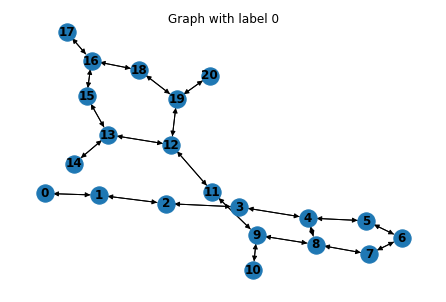

tensor([1], device='cuda:0')
0.0
------------------
0


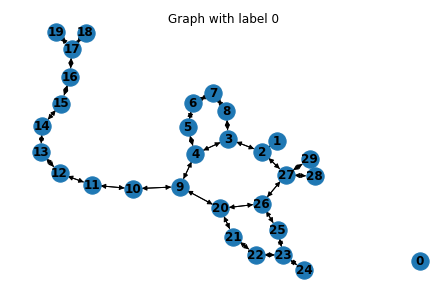

tensor([1], device='cuda:0')
0.0
------------------
0


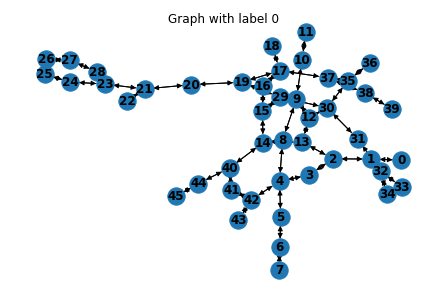

tensor([1], device='cuda:0')
0.0
------------------
0


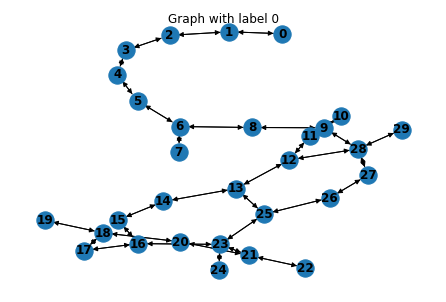

tensor([1], device='cuda:0')
0.0
------------------
0


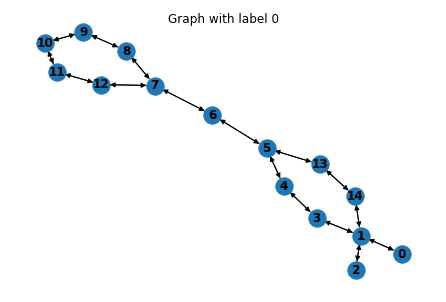

tensor([1], device='cuda:0')
0.0
------------------
0


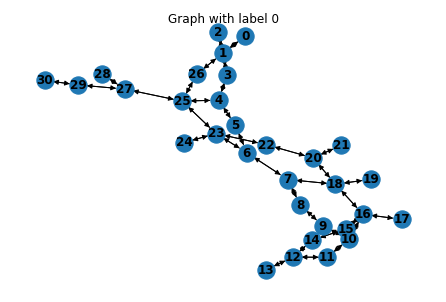

tensor([1], device='cuda:0')
0.0
------------------
0


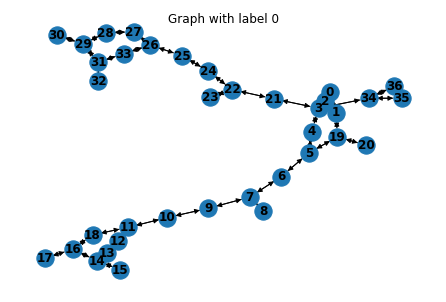

tensor([1], device='cuda:0')
0.0
------------------
0


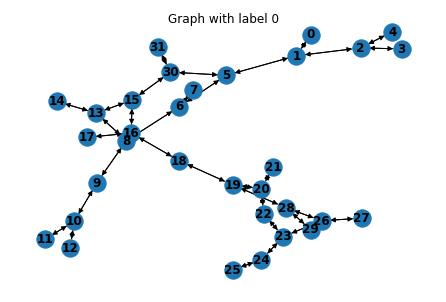

tensor([1], device='cuda:0')
0.0
------------------
1


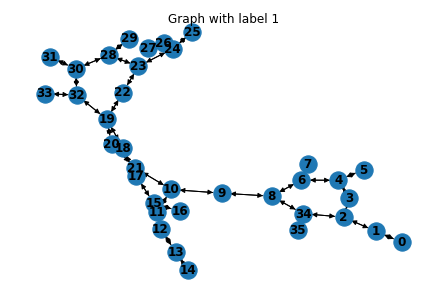

tensor([0], device='cuda:0')
1.0
------------------
0


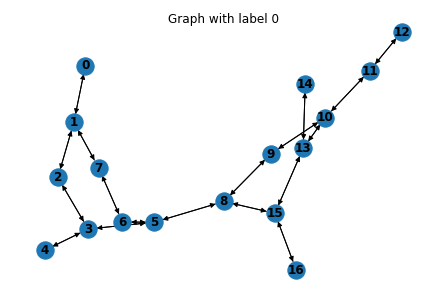

tensor([1], device='cuda:0')
0.0
------------------
0


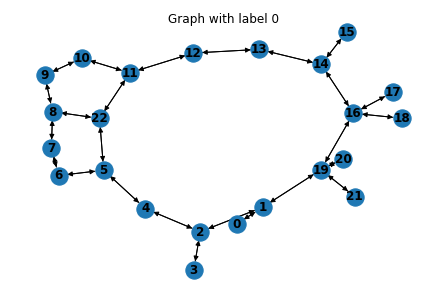

tensor([1], device='cuda:0')
0.0
------------------
0


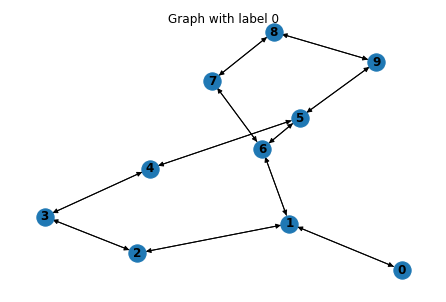

tensor([1], device='cuda:0')
0.0
------------------
0


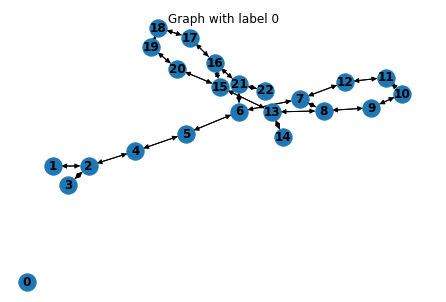

tensor([1], device='cuda:0')
0.0
------------------
0


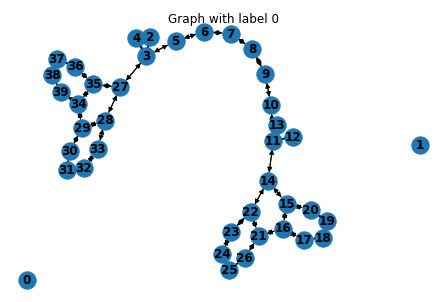

tensor([1], device='cuda:0')
0.0
------------------
0


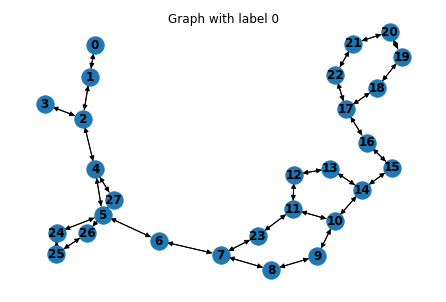

tensor([1], device='cuda:0')
0.0
------------------
0


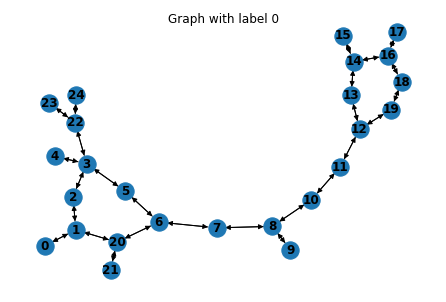

tensor([1], device='cuda:0')
0.0
------------------
0


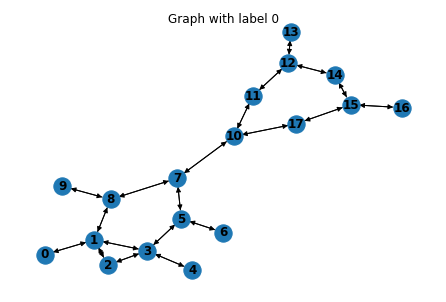

tensor([1], device='cuda:0')
0.0
------------------
1


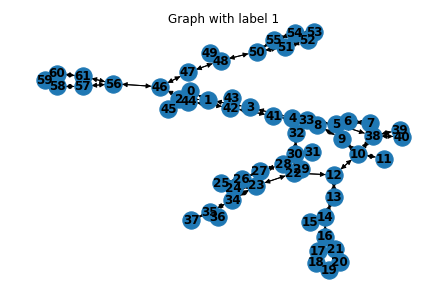

tensor([0], device='cuda:0')
1.0
------------------
0


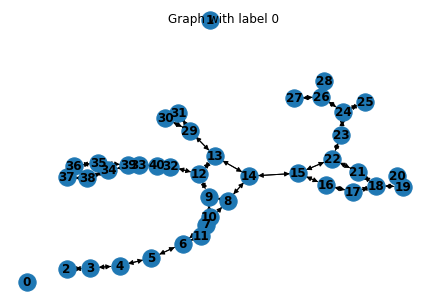

tensor([1], device='cuda:0')
0.0
------------------
0


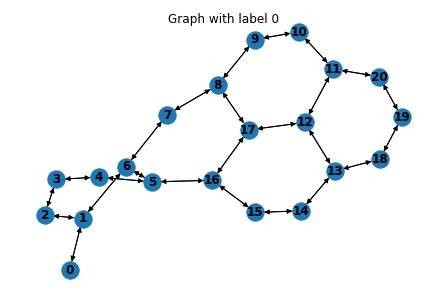

tensor([1], device='cuda:0')
0.0
------------------
0


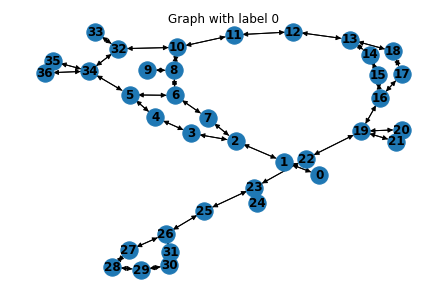

tensor([1], device='cuda:0')
0.0
------------------
0


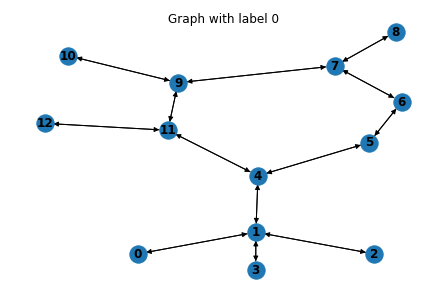

tensor([1], device='cuda:0')
0.0
------------------
1


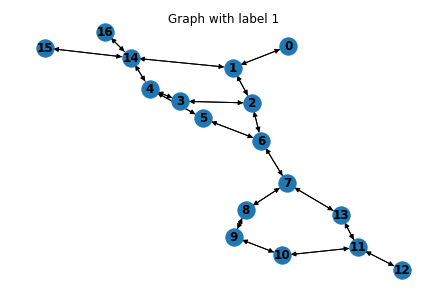

tensor([0], device='cuda:0')
1.0
------------------
0


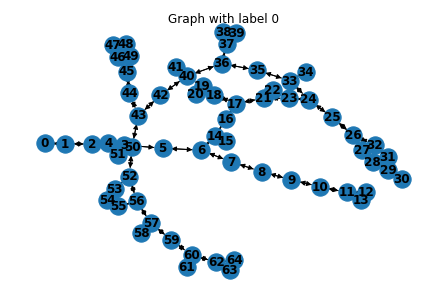

tensor([1], device='cuda:0')
0.0
------------------
0


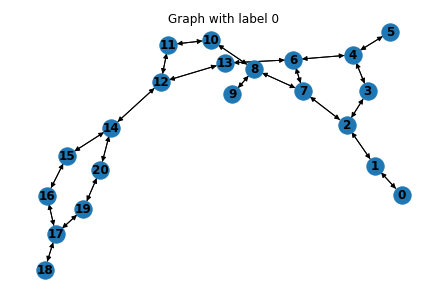

tensor([1], device='cuda:0')
0.0
------------------
0


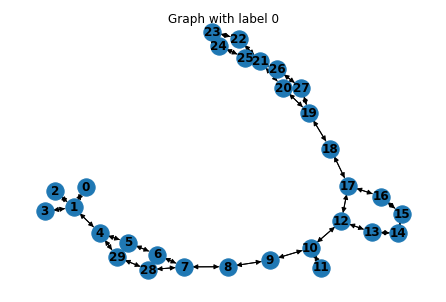

tensor([1], device='cuda:0')
0.0
------------------
0


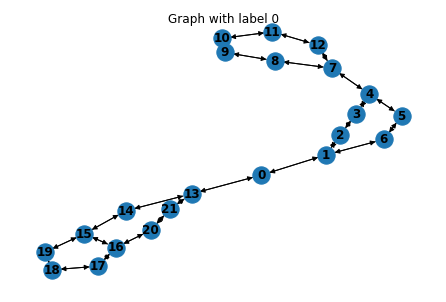

tensor([1], device='cuda:0')
0.0
------------------
0


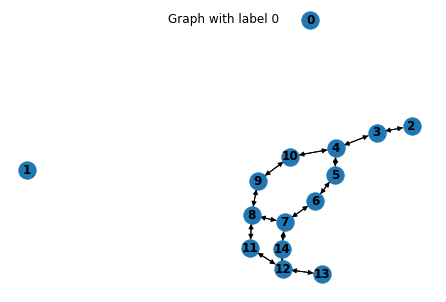

tensor([1], device='cuda:0')
0.0
------------------
0


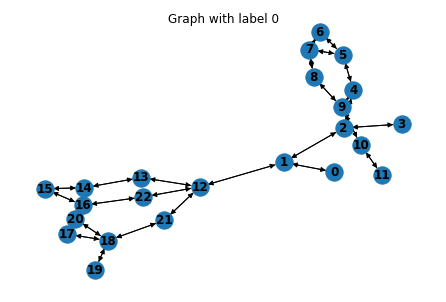

tensor([1], device='cuda:0')
0.0
------------------


In [95]:
#for graphs with wrong predictions use networkx to visualize
for i in range(len(pred)):
    if pred[i] != test_dataset.graph_labels.iloc[i, 0]:
        visualize_graph(test_dataset[i])
        print(pred[i])
        print(test_dataset.graph_labels.iloc[i, 0])
        print('------------------')

    if i == 100:
        break
